<img src="https://d3i71xaburhd42.cloudfront.net/261c3e30bae8b8bdc83541ffa9331b52fcf015e6/3-Figure2-1.png" width=50% >

# <center> Assignment 1: Photometric Stereo & Colour </center>
<center> Computer Vision 1 University of Amsterdam </center>
    <center> Due 23:59 PM, September 17, 2022 (Amsterdam time) </center>
    
***

## General guidelines
Your code and discussion must be submitted through this jupyter notebook, renamed to **StudentID1_StudentID2_StudentID3.ipynb** before the deadline by submitting it to the Canvas Lab 1 Assignment. For full credit, make sure your answer follows these guidelines:
- Please express your thoughts concisely. The number of words does not necessarily correlate with how well you understand the concepts.
- Answer all given questions.
- Try to understand the problem as much as you can. When answering a question, give evidences (qualitative and/or quantitative results, references to papers, figures etc.) to support your arguments. Note that not everything might be explicitly asked for and you are expected to think about what might strengthen you arguments and make your notebook self-contained and complete.
- Analyze your results and discuss them, e.g. why algorithm A works better than algorithm B in a certain problem.
- Tables and figures must be accompanied by a brief description. Do not forget to add a number, a title, and if applicable name and unit of variables in a table, name and unit of axes and legends in a figure.

Late submissions are not allowed. Assignments that are submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance, to avoid last minute system failure issues.
Plagiarism note: Keep in mind that plagiarism (submitted materials which are not your work) is a serious crime and any misconduct shall be punished with the university regulations.

## 0 Environment Set Up

You are allowed to use **only** the following library versions:
- python=3.10.4
- matplotlib==3.5.3
- matplotlib-inline==0.1.6
- numpy==1.23.2
- opencv-python==4.6.0.66

Using functions that are not working in these versions could lead to grade deduction.

## 1 Photometric Stereo (50pts)

In this part of the assignment, you are going to implement the photometric stereo algorithm as described in Section 5.4 (Forsyth and Ponce, *Computer Vision: A Modern Approach*). The chapter snippet can be found in the course materials.

Following this instruction, you will have to edit and fill in your code in the functions **estimate_alb_nrm**, **check_integrability**, and **construct_surface**. The main function **photometric_stereo** is provided for reference and should not be taken as is. Throughout the assignment, you will be asked to perform different trials and experiments which will require you to adjust the main code accordingly, this also shows how well you can cope with the materials.

Include images of the results into this notebook. For 3D models, make sure to choose a viewpoint that makes the structure as clear as possible and/or feel free to take them from multiple viewpoints.

### 1.1 Estimating Albedo and Surface Normal (15pts)
Let us start with the grayscale sphere model, which is located in the SphereGray5 folder. The folder contains 5 images of a sphere with grayscale checker texture under similar lighting conditions with the one in the book. Your task is to estimate the surface reflectance (albedo) and surface normal of this model. The light source directions are encoded in the image file names.

1. Complete the code for function **estimate_alb_nrm()** to estimate albedo and surface normal map for the SphereGray5 folder. What do you expect to see in albedo image and how is it different with your result?

<font color = 'red' > **Answer:** </font> **We were expecting to see clear picture of Sphere without any reflections or shadows. After running estimate_alb_nrm() function on SphereGray5 folder the image is brighter than expected and there are some reflections.**

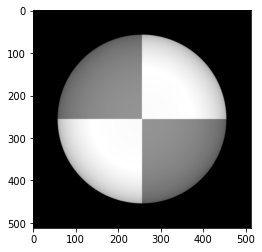


2. In principle, what is the minimum number of images you need to estimate albedo and surface normal? Run the algorithm with more images by using SphereGray25 and observe the differences in the results. You could try all images at once or a few at the time, in an incremental fashion. Choose a strategy and justify it by discussing your results.

<font color = 'red'> **Answer:** </font> **According to https://cseweb.ucsd.edu/~mkchandraker/pdf/cvpr07_shadowcuts.pdf at least 3 images are needed to reconstruct albedo and surface normal, but in practice it is common to use more images with different light sources, to improve the reconstruction accuracy. In our example we can observe that when using 25 input images the albedo and surface normal seems more accurate, because there are no reflections and the reconstructed image is more similar to the one provided in "Computer Vision a modern approach" book by Forsyth and Ponce.**


3. What is the impact of shadows in photometric stereo? Explain the trick that is used in the text to deal with shadows. Remove that trick and check your results. Is the trick necessary in the case of 5 images, how about 25 images?

<font color = 'red'> **Answer:** </font> **According to https://cseweb.ucsd.edu/~mkchandraker/pdf/cvpr07_shadowcuts.pdf shadows in photometric stereo can lead to distortion in reconstruction when not handled properly. The shadow trick is to create diagonal matrix from the image vector and multiply both sides of the equation by created matrix. This will zero out equations from points that are in shadow as stated in section 5.4 of Forsyth and Ponce book provided for this assignment.**

**SphereGray5 with the trick**


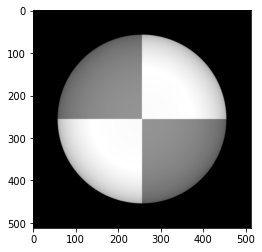

**SphereGray5 without the trick**


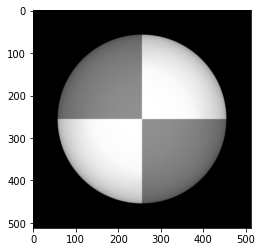

**SphereGray25 with the trick**


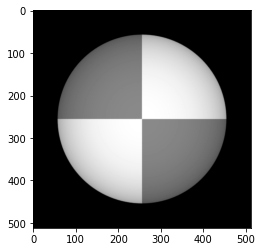


**SphereGray25 without the trick**

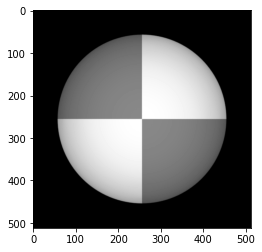

**Hint**: To get the least-squares solution of a linear system, you can use **numpy.linalg.lstsq** function.

In [28]:
# First some utils we need
import os
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def load_syn_images(image_dir='./SphereGray5/', channel=0, no_files = 0):
    files = os.listdir(image_dir)
    if no_files != 0:
      files = np.random.choice(files, no_files, replace=False)
    #files = [os.path.join(image_dir, f) for f in files]
    nfiles = len(files)
    
    image_stack = None
    V = 0
    Z = 0.5
    
    for i in range(nfiles):
        # read input image
        im = cv2.imread(os.path.join(image_dir, files[i]))
        im = im[:,:,channel]
        
        # stack at third dimension
        if image_stack is None:
            h, w = im.shape
            print('Image size (H*W): %d*%d' %(h,w) )
            image_stack = np.zeros([h, w, nfiles], dtype=int)
            V = np.zeros([nfiles, 3], dtype=np.float64)
            
        image_stack[:,:,i] = im
        
        # read light direction from image name
        X = np.double(files[i][(files[i].find('_')+1):files[i].rfind('_')])
        Y = np.double(files[i][files[i].rfind('_')+1:files[i].rfind('.png')])
        V[i, :] = [-X, Y, Z]
        
    # normalization
    image_stack = np.double(image_stack)
    min_val = np.min(image_stack)
    max_val = np.max(image_stack)
    image_stack = (image_stack - min_val) / (max_val - min_val)
    normV = np.tile(np.sqrt(np.sum(V ** 2, axis=1, keepdims=True)), (1, V.shape[1]))
    scriptV = V / normV
    
    return image_stack, scriptV
    
    
def load_face_images(image_dir='./yaleB02/'):
    num_images = 64
    filename = os.path.join(image_dir, 'yaleB02_P00_Ambient.pgm')
    ambient_image = cv2.imread(filename, -1)
    h, w = ambient_image.shape

    # get list of all other image files
    import glob 
    d = glob.glob(os.path.join(image_dir, 'yaleB02_P00A*.pgm'))
    import random
    d = random.sample(d, num_images)
    filenames = [os.path.basename(x) for x in d]

    ang = np.zeros([2, num_images])
    image_stack = np.zeros([h, w, num_images])

    for j in range(num_images):
        ang[0,j], ang[1,j] = np.double(filenames[j][12:16]), np.double(filenames[j][17:20])
        image_stack[...,j] = cv2.imread(os.path.join(image_dir, filenames[j]), -1) - ambient_image


    x = np.cos(np.pi*ang[1,:]/180) * np.cos(np.pi*ang[0,:]/180)
    y = np.cos(np.pi*ang[1,:]/180) * np.sin(np.pi*ang[0,:]/180)
    z = np.sin(np.pi*ang[1,:]/180)
    scriptV = np.array([y,z,x]).transpose(1,0)

    image_stack = np.double(image_stack)
    image_stack[image_stack<0] = 0
    min_val = np.min(image_stack)
    max_val = np.max(image_stack)
    image_stack = (image_stack - min_val) / (max_val - min_val)
    
    return image_stack, scriptV


def load_apple_images(image_dir='./Apples_png/'):
    num_images = 100
    filename = os.path.join(image_dir, 'I_0000.png')
    try_image = cv2.imread(filename, -1)
    h, w = try_image[:,:,0].shape

    # get list of all other image files
    import glob 
    d = glob.glob(os.path.join(image_dir, 'I_00*.png'))
    import random
    d = random.sample(d, num_images)
    filenames = [os.path.basename(x) for x in d]
    filenames_idx = []
    for i in filenames:
        filenames_idx.append(int(i.split('_')[1].split('.')[0]))

    ang = np.zeros([2, num_images])
    image_stack = np.zeros([h, w, num_images])

    for j in range(num_images):
        image_stack[...,j] = cv2.imread(os.path.join(image_dir, filenames[j]), -1)[:,:,0]
        
    with open('./images/photometrics_images/Apple/light_directions_refined.txt') as file:
        lines = [line.split() for line in file]
        x, y, z = [], [], []
        for idx in filenames_idx:
            x.append(float(lines[idx][0]))
            y.append(float(lines[idx][1]))
            z.append(float(lines[idx][2]))

    scriptV = np.array([y,z,x]).transpose(1,0)

    image_stack = np.double(image_stack)
    image_stack[image_stack<0] = 0
    min_val = np.min(image_stack)
    max_val = np.max(image_stack)
    image_stack = (image_stack - min_val) / (max_val - min_val)
    
    return image_stack, scriptV
    
    
def show_results(albedo, normals, height_map, SE):
    # Stride in the plot, you may want to adjust it to different images
    stride = 1
    
    # showing albedo map
    fig = plt.figure()
    albedo_max = albedo.max()
    albedo_max = 1
    albedo = albedo / albedo_max
    print(albedo.shape)
    plt.imshow(albedo, cmap="gray")
    plt.show()
    
    # showing normals as three separate channels
    figure = plt.figure()
    ax1 = figure.add_subplot(131)
    ax1.imshow(normals[..., 0])
    ax2 = figure.add_subplot(132)
    ax2.imshow(normals[..., 1])
    ax3 = figure.add_subplot(133)
    ax3.imshow(normals[..., 2])
    plt.show()
    
    # meshgrid
    X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], stride),
    np.arange(0,np.shape(normals)[1], stride),
    np.arange(1))
    X = X[..., 0]
    Y = Y[..., 0]
    
    '''
    =============
    You could further inspect the shape of the objects and normal directions by using plt.quiver() function.  
    =============
    '''
    
    # plotting the SE
    H = SE[::stride,::stride]
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()
    
    # plotting model geometry
    H = height_map[::stride,::stride]
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()


In [5]:
def estimate_alb_nrm( image_stack, scriptV, shadow_trick=True):
    
    # COMPUTE_SURFACE_GRADIENT compute the gradient of the surface
    # INPUT:
    # image_stack : the images of the desired surface stacked up on the 3rd dimension
    # scriptV : matrix V (in the algorithm) of source and camera information
    # shadow_trick: (true/false) whether or not to use shadow trick in solving linear equations
    # OUTPUT:
    # albedo : the surface albedo
    # normal : the surface normal

    h, w, _ = image_stack.shape
    
    # create arrays for 
    # albedo (1 channel)
    # normal (3 channels)
    albedo = np.zeros([h, w])
    normal = np.zeros([h, w, 3])
    
    """
    ================
    Your code here
    ================
    for each point in the image array
        stack image values into a vector i
        construct the diagonal matrix scriptI
        solve scriptI * scriptV * g = scriptI * i to obtain g for this point
        albedo at this point is |g|
        normal at this point is g / |g|
    """
    
    for x in range(h):
        for y in range(w):
            i = np.squeeze(image_stack[x,y,:])
            if shadow_trick:
                scriptI = np.diag(i)
                g = np.linalg.lstsq(scriptI.dot(scriptV), scriptI.dot(i), rcond = None)
            else:
                g = np.linalg.lstsq(scriptV, i)

            albedo[x, y] = np.linalg.norm(g[0])
            normal[x, y, :] = g[0]/np.linalg.norm(g[0])

    
    
    return albedo, normal
    
# if __name__ == '__main__':
#     n = 5
#     image_stack = np.ones([5,5,n])
#     scriptV = np.ones([n,3])
#     estimate_alb_nrm( image_stack, scriptV, shadow_trick=True)

### 1.2 Test of Integrability (10pts)

Before we can reconstruct the surface height map, it is required to compute the partial derivatives $\frac{\delta f}{\delta x}$ and $\frac{\delta f}{\delta y}$ (or *p* and *q* in the algorithm). The partial derivatives also give us a chance to double check our computation, namely the test of *integrability*.

1. Compute the partial derivatives (p and q in the algorithm) by filling in your code into **check_integrability()**.

In [6]:
def check_integrability(normals):
    #  CHECK_INTEGRABILITY check the surface gradient is acceptable
    #   normals: normal image
    #   p : df / dx
    #   q : df / dy
    #   SE : Squared Errors of the 2 second derivatives

    # initalization
    p = np.zeros(normals.shape[:2])
    q = np.zeros(normals.shape[:2])
    SE = np.zeros(normals.shape[:2])
    
    """
    ================
    Your code here
    ================
    Compute p and q, where
    p measures value of df / dx
    q measures value of df / dy
    
    """
    a = normals[:,:,0] #normals[0]
    b = normals[:,:,1]
    c = normals[:,:,2]

    p = a / c
    q = b / c
    
    # change nan to 0
    p[p!=p] = 0
    q[q!=q] = 0
    
    """
    ================
    Your code here
    ================
    approximate second derivate by neighbor difference
    and compute the Squared Errors SE of the 2 second derivatives SE
    
    """
    p2 = np.gradient(p)[0]
    q2 = np.gradient(q)[1]
    SE = (p2 - q2) ** 2

    return p, q, SE

# if __name__ == '__main__':
#     normals = np.zeros([10,10,3])
#     p, q, SE = check_integrability(normals)

2. Implement and compute the second derivatives according to the algorithm and perform the test of integrability by choosing a reasonable threshold. What could be the reasons for the errors? How does the test perform with different number of images used in the reconstruction process in Question 1?

<font color = 'red'> **Answer:**</font> **The main reason for the errors will be the number of images used. If we are using only few images with different light sources it is hard to properly reconstruct the image because some parts of the image may be in shade in every input image. To solve that problem we could increase number of source images.**

### 1.3 Shape by Integration (10pts)
To reconstruct the surface height map, we need to continuously integrate the partial derivatives over a path. However, as we are working with discrete structures, you will be simply summing their values.

The algorithm in the chapter presents a way to do the integration in column-major order, that is you start at the top-left corner and integrate along the first column, then go towards right along each row. Yet, it is also noticed that it would be better to use many different paths and average so as to spread around the errors in the derivative estimates.

1. Construct the surface height map using column-major order as described in the algorithm, then implement row-major path integration. Your code should now go to **construct_surface()**.

**Note**: By default, Numpy used row-major operations. So if you are unrolling an image to linearize the operation, you will end up with a row-major representation. Numpy can be configured to be column-major. Otherwise, if you are using the double for-loops without an unrolling operation, then this concern doesn’t apply.

**Hint**: You could further inspect the shape of the objects and normal directions by using **matplotlib.pyplot.quiver** function. You will have to choose appropriate sub-sampling ratios for proper illustration. You code goes to the **show_results()** in the first code cell.

In [7]:
def construct_surface(p, q, path_type='column'):

    '''
    CONSTRUCT_SURFACE construct the surface function represented as height_map
       p : measures value of df / dx
       q : measures value of df / dy
       path_type: type of path to construct height_map, either 'column',
       'row', or 'average'
       height_map: the reconstructed surface
    '''
    
    h, w = p.shape
    height_map = np.zeros([h, w])
    
    if path_type=='column':
        """
        ================
        Your code here
        ================
        % top left corner of height_map is zero
        % for each pixel in the left column of height_map
        %   height_value = previous_height_value + corresponding_q_value
        
        % for each row
        %   for each element of the row except for leftmost
        %       height_value = previous_height_value + corresponding_p_value
        
        """
        for y in range(1, h):
            height_map[y, 0] = height_map[y-1, 0] + q[y, 0]
        
        for y in range(h):
            for x in range(1,w):
                height_map[y, x] = height_map[y, x-1] + p[y, x]
        
        
        
    elif path_type=='row':
        """
        ================
        Your code here
        ================
        """
        for x in range(1, w):
            height_map[0, x] = height_map[0, x-1] + p[0, x]
            
        for x in range(w):
            for y in range(1, h):
                height_map[y, x] = height_map[y-1, x] + q[y, x]
        
    elif path_type=='average':
        """
        ================
        Your code here
        ================
        """
        height_map_col = construct_surface(p, q, path_type='column')
        height_map_row = construct_surface(p, q, path_type='row')

        height_map = (height_map_col + height_map_row) / 2
        
    return height_map

2. What are the differences in the results of the two paths?

<font color = 'red'> **Answer** </font> The difference in the result for row and column path is that the resulting image of height map is rotated by 90 degrees and flipped.

**Column path**

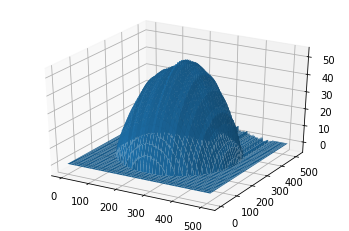


**Row path**

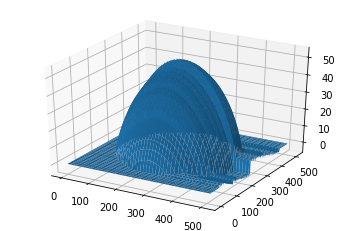



3. Now, take the average of the results. Do you see any improvement compared to when using only one path? Are the construction results different with different number of images being used?

<font color = 'red'> **Answer:** </font> **For average path results look better than for column and row path separately. The results also differ for 25 images compared to 5. For 25 images height map is more uniform and smooth.**

**Average path 5 images**

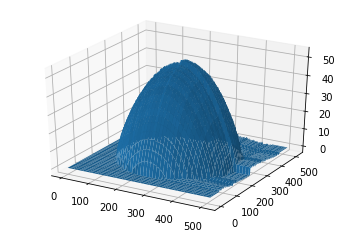

**Average path 25 images**

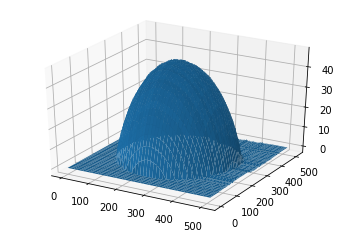



### 1.4 Experiments with different objects (15pts)
In this part, you will try to run the photometric stereo algorithm in various number of scenarios to see how well it can be generalized.

1. Run the algorithm and show the results for the MonkeyGray model. 

**Results:**

Loading images...

Image size (H*W): 512*512
Finish loading 121 images.

Computing surface albedo and normal map...



/var/folders/nf/nlqft1994556cpj2_qmx79sm0000gp/T/ipykernel_52818/1866860923.py:42: RuntimeWarning: invalid value encountered in divide
  normal[x, y, :] = g[0]/np.linalg.norm(g[0])


Integrability checking

Number of outliers: 4546

(512, 512)


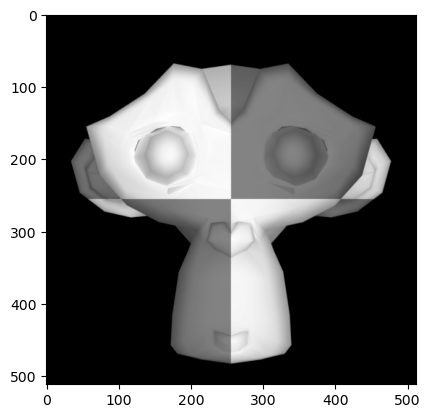

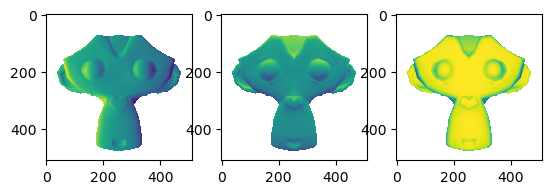

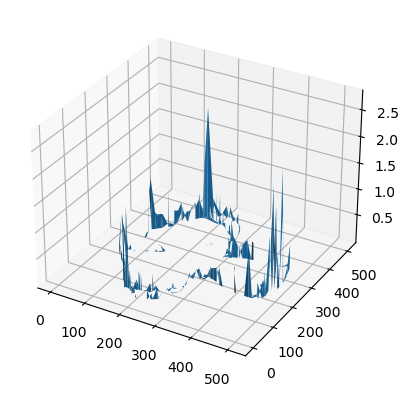

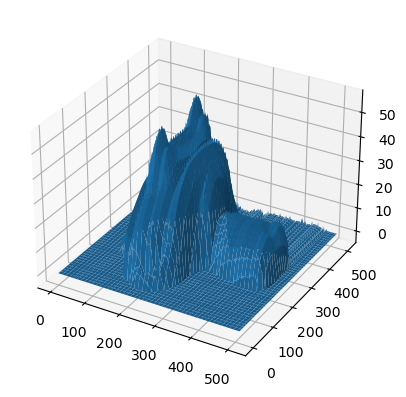

In [13]:
photometric_stereo(r'./images/photometrics_images/MonkeyGray/', shadow_trick=True, path_type = 'column')

In [1]:
def photometric_stereo(image_dir='./SphereGray5/', shadow_trick = True, path_type = 'column', no_files = 0):

    # obtain many images in a fixed view under different illumination
    print('Loading images...\n')
    [image_stack, scriptV] = load_syn_images(image_dir, no_files = no_files)
    [h, w, n] = image_stack.shape
    print('Finish loading %d images.\n' % n)

    # compute the surface gradient from the stack of imgs and light source mat
    print('Computing surface albedo and normal map...\n')
    [albedo, normals] = estimate_alb_nrm(image_stack, scriptV, shadow_trick = shadow_trick)


    # integrability check: is (dp / dy  -  dq / dx) ^ 2 small everywhere?
    print('Integrability checking\n')
    [p, q, SE] = check_integrability(normals)

    threshold = 0.005;
    print('Number of outliers: %d\n' % np.sum(SE > threshold))
    SE[SE <= threshold] = float('nan') # for good visualization

    # compute the surface height
    height_map = construct_surface( p, q , path_type)

    # show results
    show_results(albedo, normals, height_map, SE)


## Face
def photometric_stereo_face(image_dir='./yaleB02/', shadow_trick = True, path_type = 'column'):
    [image_stack, scriptV] = load_face_images(image_dir)
    [h, w, n] = image_stack.shape
    print('Finish loading %d images.\n' % n)
    print('Computing surface albedo and normal map...\n')
    albedo, normals = estimate_alb_nrm(image_stack, scriptV, shadow_trick = shadow_trick)

    # integrability check: is (dp / dy  -  dq / dx) ^ 2 small everywhere?
    print('Integrability checking')
    p, q, SE = check_integrability(normals)

    threshold = 0.005;
    print('Number of outliers: %d\n' % np.sum(SE > threshold))
    SE[SE <= threshold] = float('nan') # for good visualization

    # compute the surface height
    height_map = construct_surface(p, q , path_type)

    # show results
    show_results(albedo, normals, height_map, SE)
    
## Apple
def photometric_stereo_apple(image_dir='./Apple_png/', shadow_trick = True, path_type = 'column'):
    [image_stack, scriptV] = load_apple_images(image_dir)
    [h, w, n] = image_stack.shape
    print('Finish loading %d images.\n' % n)
    print('Computing surface albedo and normal map...\n')
    albedo, normals = estimate_alb_nrm(image_stack, scriptV, shadow_trick = shadow_trick)

    # integrability check: is (dp / dy  -  dq / dx) ^ 2 small everywhere?
    print('Integrability checking')
    p, q, SE = check_integrability(normals)

    threshold = 0.005;
    print('Number of outliers: %d\n' % np.sum(SE > threshold))
    SE[SE <= threshold] = float('nan') # for good visualization

    # compute the surface height
    height_map = construct_surface(p, q, path_type)

    # show results
    show_results(albedo, normals, height_map, SE)
    
def photometric_stereo_color(image_dir='./SphereGray5/', shadow_trick = True, path_type = 'column', no_files = 0):

    # obtain many images in a fixed view under different illumination
    print('Loading images...\n')
    for channel in range(3):
        [image_stack, scriptV] = load_syn_images(image_dir, no_files = no_files, channel = channel)
        [h, w, n] = image_stack.shape
        print('Finish loading %d images.\n' % n)

        # compute the surface gradient from the stack of imgs and light source mat
        print('Computing surface albedo and normal map...\n')
        [albedo, normals] = estimate_alb_nrm(image_stack, scriptV, shadow_trick = shadow_trick)


        # integrability check: is (dp / dy  -  dq / dx) ^ 2 small everywhere?
        print('Integrability checking\n')
        [p, q, SE] = check_integrability(normals)

        threshold = 0.005;
        print('Number of outliers: %d\n' % np.sum(SE > threshold))
        SE[SE <= threshold] = float('nan') # for good visualization

        # compute the surface height
        height_map = construct_surface( p, q , path_type)

        # show results
        show_results(albedo, normals, height_map, SE)

    
# if __name__ == '__main__':
#     photometric_stereo(r'./images/photometrics_images/SphereGray5/')
#     photometric_stereo_face(r'./images/photometrics_images/yaleB02/')
#     photometric_stereo_apple(r'./images/photometrics_images/Apple/')


2. The albedo results of the monkey may comprise more albedo errors than in case of the sphere. Observe and describe the errors. What could be the reason for those errors? You may want to experiment with different number of images as you did in Question 1 to see the effects. 

<font color = 'red'> **Answer**: </font> **For monkey we can except more albedo errors than in case of the sphere because shape of monkey image is more complicated than the shape of sphere and therefore we need more input images with different light sources to reconstruct albedo properly. We can see it by comparing albedo results for 5, 25 and all provided images (for 5 and 25 images were selected randomly). Below we present albedo results for each of this cases. As we can see for 5 images result doesn't seem right because we can see a lot of shadows and some reflections. For 25 images the result looks almost identical when comparing to calculating albedo for all provided images (121).**

**Code used to generate images is provided below**

**5 randomly selected images**

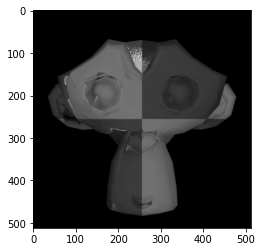

**25 randomly selected images**

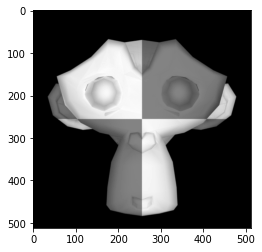

**All provided images (121)**

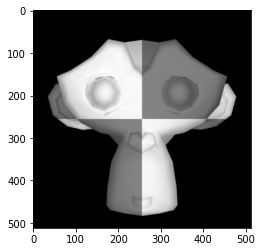



In [ ]:
photometric_stereo(r'./images/photometrics_images/MonkeyGray/', shadow_trick=True, path_type = 'column', no_files = 5)

In [ ]:
photometric_stereo(r'./images/photometrics_images/MonkeyGray/', shadow_trick=True, path_type = 'column', no_files = 25)

In [ ]:
photometric_stereo(r'./images/photometrics_images/MonkeyGray/', shadow_trick=True, path_type = 'column')

3. How do you think that could help solving these errors?

<font color = 'red'> **Answer:** </font> **To solve this error we could add more source images from different angles to be able to reconstruct true albedo and surface of the image.**



So far, we have assumed that albedos are 1-channel grayscale images and that input images are also 1-channel. To work with 3-channel images, a simple solution is to split the input image into separate channels and treat them individually. Yet, that would generate a small problem while constructing the surface normal map if a pixel value in a channel is zero.

1. Update the implementation to work for 3-channel RGB inputs and test it with 2 models SphereColor and MonkeyColor. 
2. Explain your changes and show your results. 

<font color = 'red'> **Answer**:</font> **We've created the function photometric_stereo_color similar to the function provided. The only change that we made is that, the function photometric_stereo_color iterates through all the channels and calculates albedo, surface normal, SE and height map for each channel separately. Results of that are presented below. First function shows the results for SphereColor, second for MonkeyColor. In both cases results follow the channels order which is `blue`, `green`, `red`**

Loading images...

Image size (H*W): 512*512
Finish loading 25 images.

Computing surface albedo and normal map...



/var/folders/nf/nlqft1994556cpj2_qmx79sm0000gp/T/ipykernel_52818/1866860923.py:42: RuntimeWarning: invalid value encountered in divide
  normal[x, y, :] = g[0]/np.linalg.norm(g[0])


Integrability checking

Number of outliers: 17234

(512, 512)


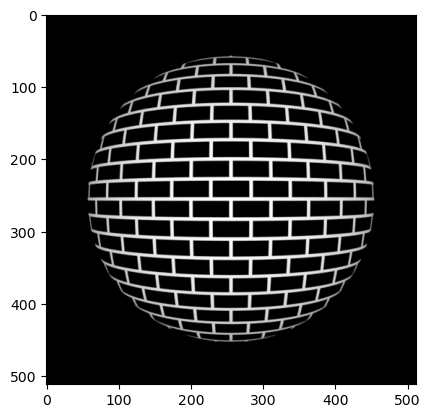

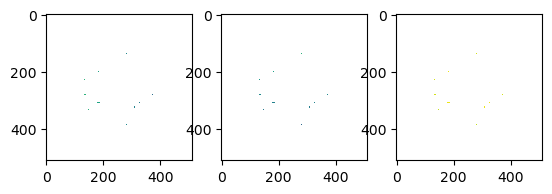

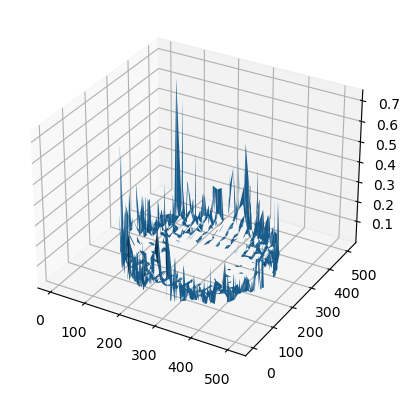

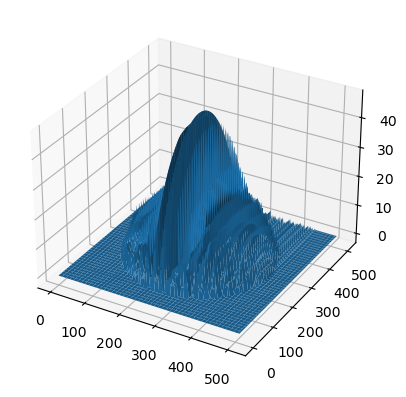

Image size (H*W): 512*512
Finish loading 25 images.

Computing surface albedo and normal map...

Integrability checking

Number of outliers: 14245

(512, 512)


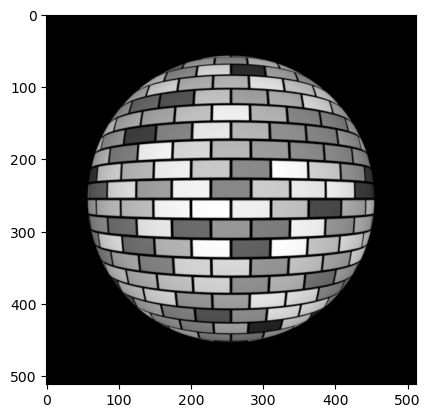

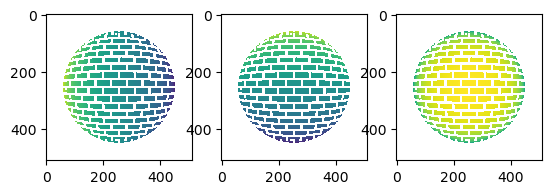

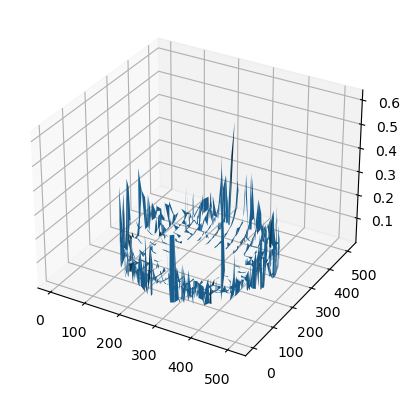

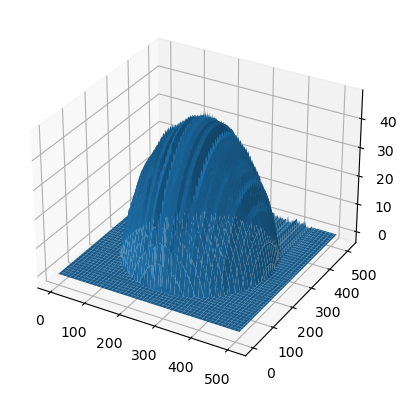

Image size (H*W): 512*512
Finish loading 25 images.

Computing surface albedo and normal map...

Integrability checking

Number of outliers: 14425

(512, 512)


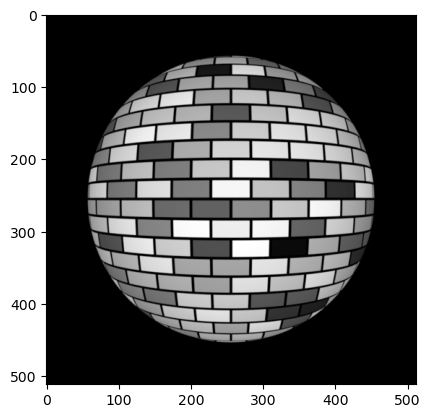

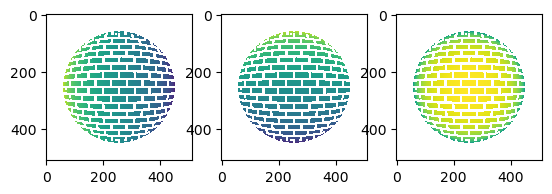

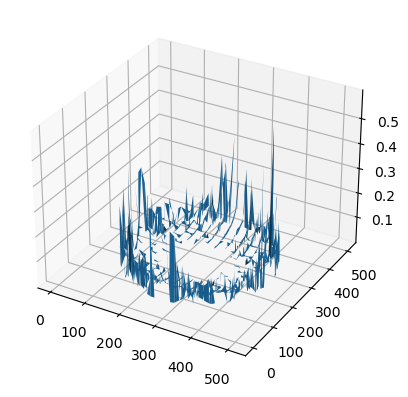

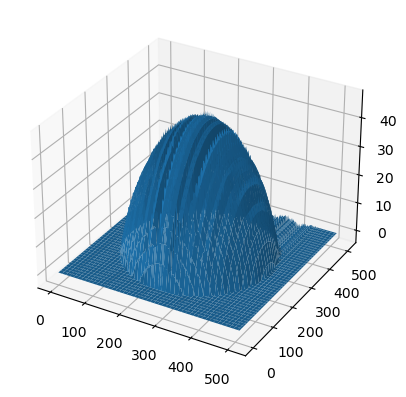

In [21]:
photometric_stereo_color(r'./images/photometrics_images/SphereColor/', shadow_trick=True)

Loading images...

Image size (H*W): 512*512
Finish loading 121 images.

Computing surface albedo and normal map...



/var/folders/nf/nlqft1994556cpj2_qmx79sm0000gp/T/ipykernel_52818/1866860923.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(scriptV, i)
/var/folders/nf/nlqft1994556cpj2_qmx79sm0000gp/T/ipykernel_52818/1866860923.py:42: RuntimeWarning: invalid value encountered in divide
  normal[x, y, :] = g[0]/np.linalg.norm(g[0])


Integrability checking

Number of outliers: 4248

(512, 512)


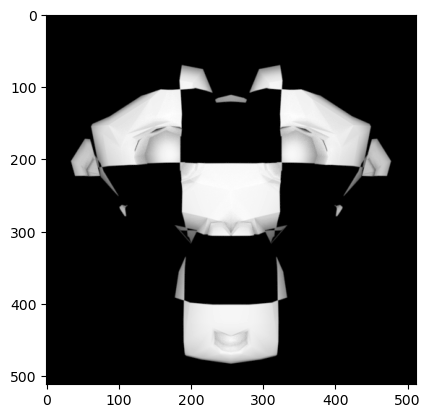

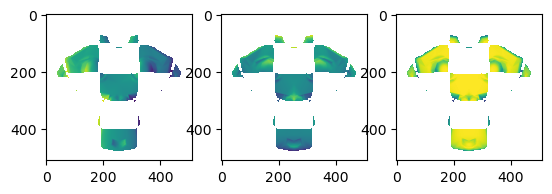

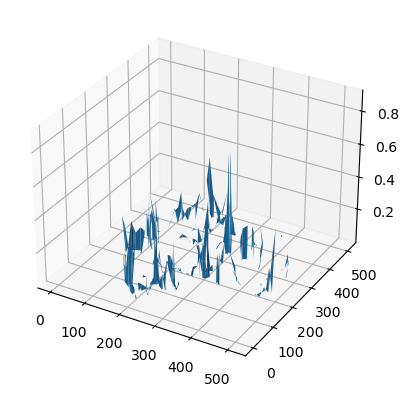

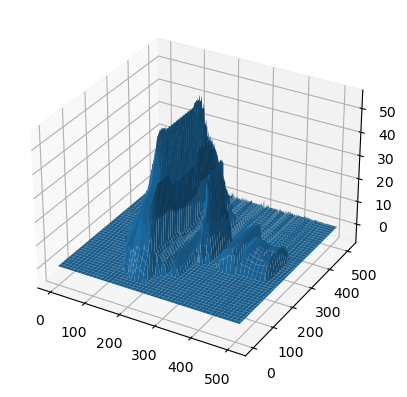

Image size (H*W): 512*512


/var/folders/nf/nlqft1994556cpj2_qmx79sm0000gp/T/ipykernel_52818/2340031884.py:43: RuntimeWarning: invalid value encountered in divide
  image_stack = (image_stack - min_val) / (max_val - min_val)


Finish loading 121 images.

Computing surface albedo and normal map...

Integrability checking

Number of outliers: 0

(512, 512)


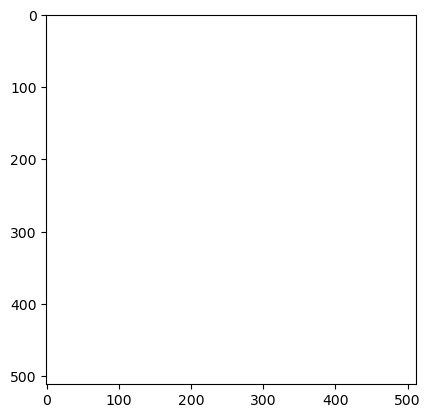

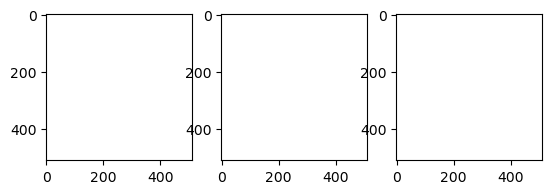

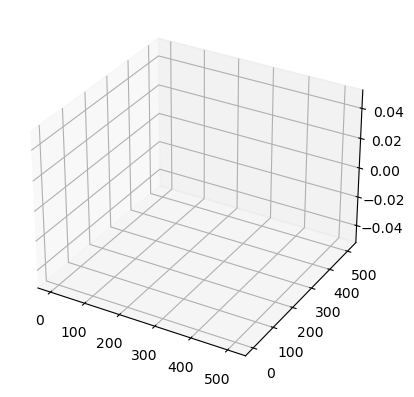

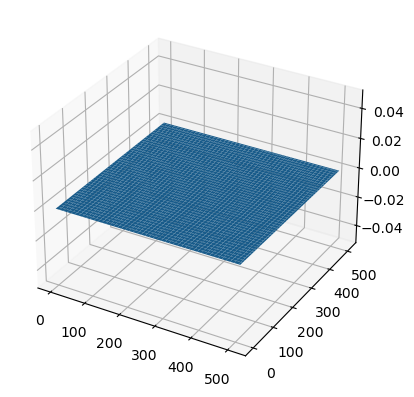

Image size (H*W): 512*512
Finish loading 121 images.

Computing surface albedo and normal map...

Integrability checking

Number of outliers: 4868

(512, 512)


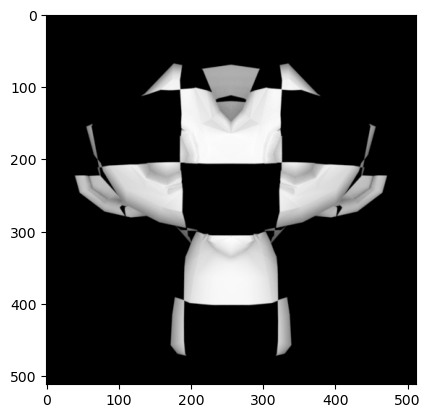

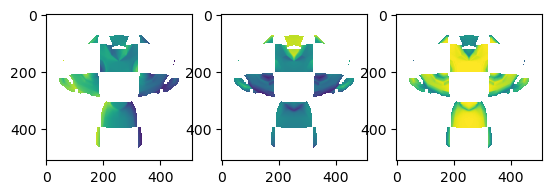

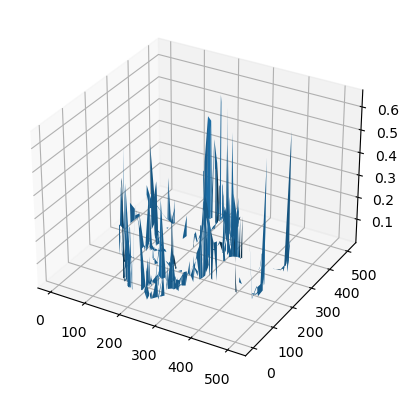

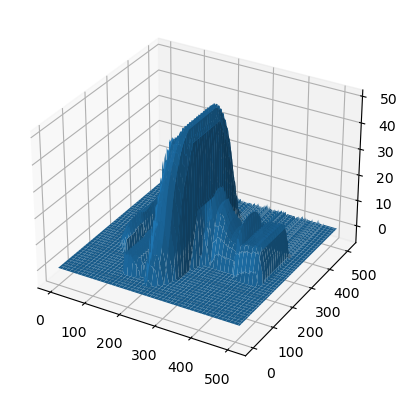

In [23]:
photometric_stereo_color(r'./images/photometrics_images/MonkeyColor/', shadow_trick=False)

3. Observe the problem in the constructed surface normal map and height map, explain why a zero pixel could be a problem and propose a way to overcome that.

<font color = 'red'> **Answer**:</font> **Because for RGB images we treat each channel separately we will get a lot o zero pixels for some channels. One possible to overcome this problem is to create the heightmap by averaging results from each channel.**

Now, it's the time to try the algorithm on real-world datasets. For that purpose, we are going to use the [Yale Face Database](http://cvc.cs.yale.edu/cvc/projects/yalefaces/yalefaces.html)

1. Run the algorithm for the Yale Face images (included in the lab material). 
2. Observe and discuss the results for different integration paths. 

**Hint**: For proper computation of albedo and surface normal, you may want to suspend the shadow trick described in the text, and use the original formula:
$$i = Vg(x,y)$$

<font color = 'red'> **Answer:** </font>
**The three integration paths compared are `average`, `column` and `row` (the images below are in that order). For the column path height map for the face looks flattened, for row path height map has higher amplitude and for average path as expected face looks closer to natural shape.**


**Average path**

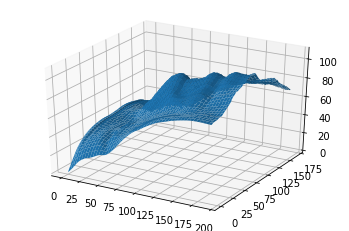

**Column path**

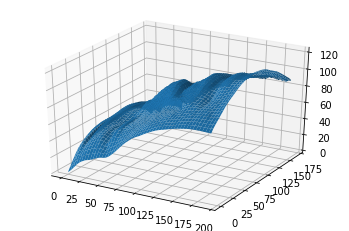

**Row path**

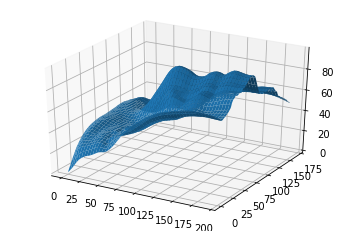

3. Discuss how the images violate the assumptions of the shape-from-shading methods. Remember to include specific input images to illustrate your points. 


<font color = 'red'> **Answer:**</font> Shape-from-shading methods should be able to reconstruct the information of the 3D shape with just single image. In this situation however, multiple images are used. The assumption here is that the light-source comes from a singular place.<br>
The image below is one of the input-images. The brightest point of the image is the tip of his nose.

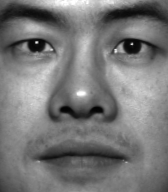

The next image has light coming from the right side, with the brightest point being the side of his nose.

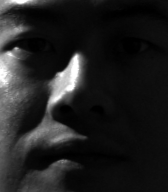

**Many more of the input images have light coming from all different kind of directions. Resulting in light being all over the place in the output image (as can be seen in exercises prior, showing the `photometric_stereo_face`). The violation that this causes is of the assumption that it is ideal diffuse, which in turn causes the model to create and estimate the wrong values for the albedo image.

4. How would the results improve when the problematic images are all removed? Try it out and show the results here.

<font color = 'red'> **Answer:**</font>
Removing the problematic images would mean removing part of the outliers, and also less uncertainty in places where that wouldn't have to be necessary. Resulting in less errors.** <br>
**The dataset contained two images that caused problems, one being extremely pixelated and one having coloured stripes across. Removing these two from the dataset, updating n to 62 and running the code again gives a different output for the SE-plot.

**Important**
Removed files:
yaleB02_P00A+095E+00
yaleB02_P00A+025E+00

**First plot shows error before removing problematic and second one after removing them**

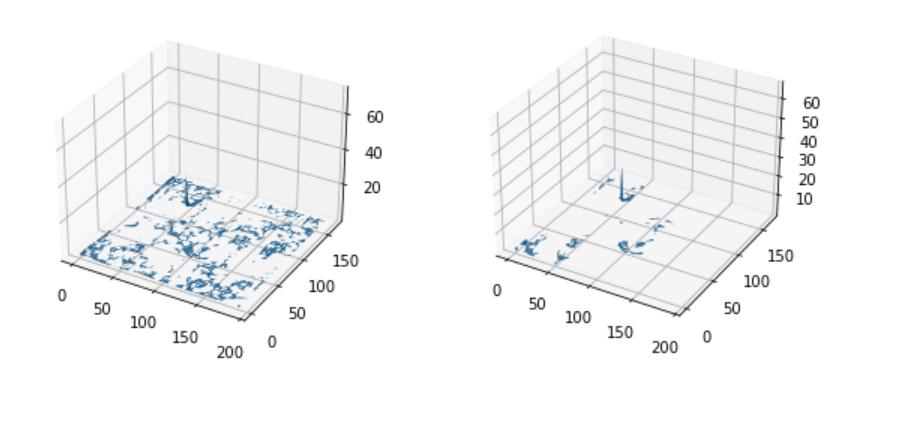

Finally, show your results on real-world 3-channel RGB inputs, contained in the "Apple" folder, taken from [this dataset](http://vision.ucsd.edu/~nalldrin/research/cvpr08/datasets/) from the University of California San Diego.

1. Observe and discuss the results for different integration paths. 

<font color = 'red'> **Answer** </font> **Results are presented below, for all paths results do not look fine**

Finish loading 100 images.

Computing surface albedo and normal map...



/var/folders/nf/nlqft1994556cpj2_qmx79sm0000gp/T/ipykernel_53463/1866860923.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(scriptV, i)


Integrability checking
Number of outliers: 215234

(696, 646)


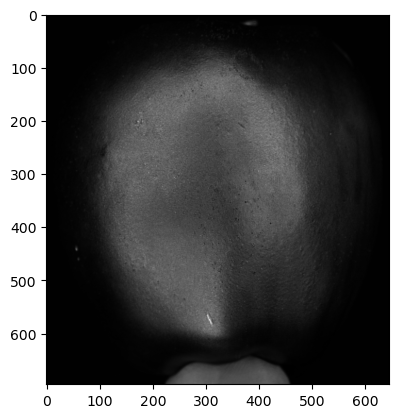

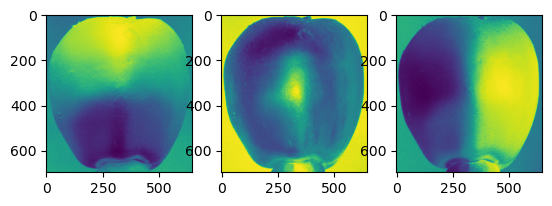

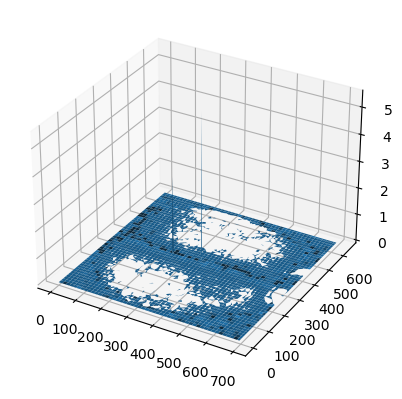

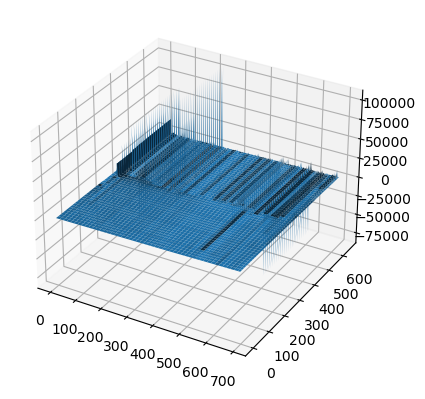

In [29]:
photometric_stereo_apple(r'./images/photometrics_images/Apple/', shadow_trick = False, path_type='column')

Finish loading 100 images.

Computing surface albedo and normal map...



/var/folders/nf/nlqft1994556cpj2_qmx79sm0000gp/T/ipykernel_53463/1866860923.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(scriptV, i)


Integrability checking
Number of outliers: 215234

(696, 646)


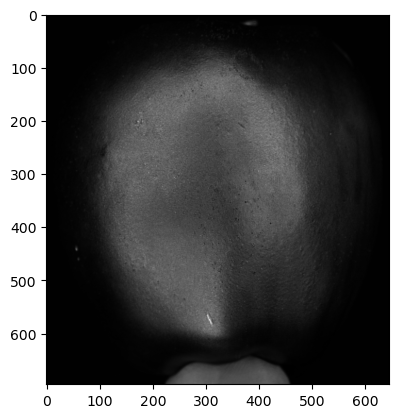

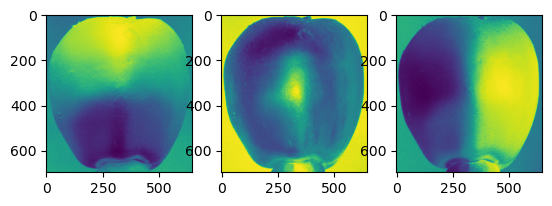

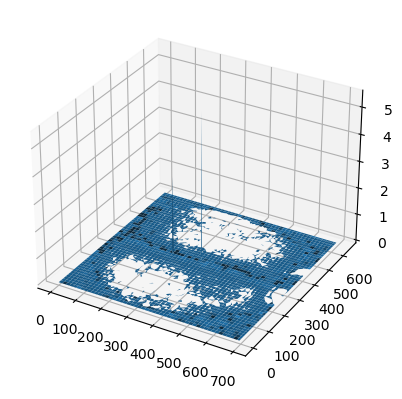

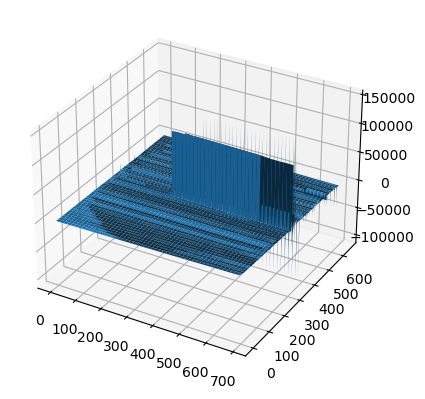

In [30]:
photometric_stereo_apple(r'./images/photometrics_images/Apple/', shadow_trick = False, path_type='row')

Finish loading 100 images.

Computing surface albedo and normal map...



/var/folders/nf/nlqft1994556cpj2_qmx79sm0000gp/T/ipykernel_53463/1866860923.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(scriptV, i)


Integrability checking
Number of outliers: 215234

(696, 646)


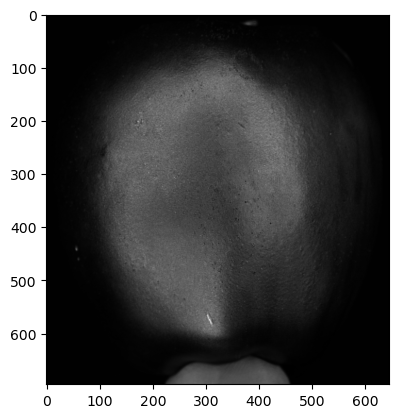

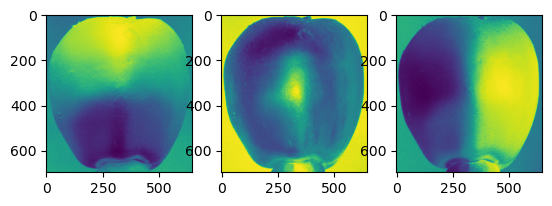

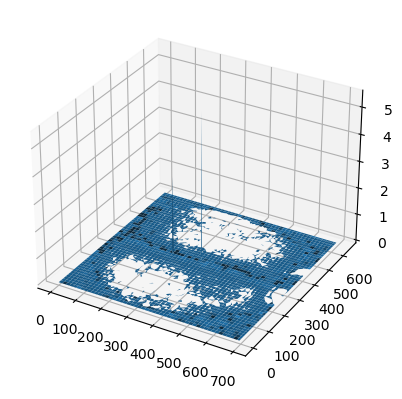

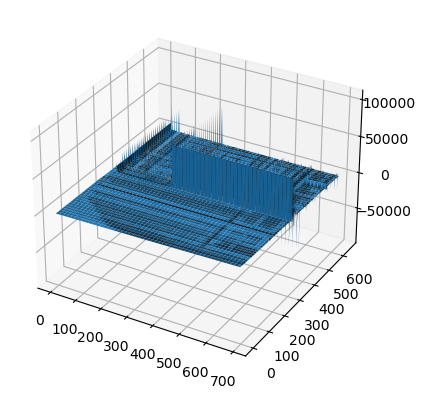

In [32]:
photometric_stereo_apple(r'./images/photometrics_images/Apple/', shadow_trick = False, path_type='average')

## 2 Colour Spaces (20pts)

In this part of the assignment, you will study the different colour spaces for image representations and experiment how to convert a given RGB image to a specific colour space.

### 2.1 RGB Colour Model (3pts)

Why do we use RGB colour model as a basis of our digital cameras and photography? How does a standard digital camera capture the full RGB colour image? 
Any spectral colour can be defined as a linear combination of these three primary colours.

The colour of each image pixel is represented by a vector with three values defining the intensity/proportion of the three primary colours: Red, Blue and Green.
Therefore, for the whole image (NxN pixels), a digital camera stores three matrices: R(NxN), G(NxN), and B(NxN) each storing the intensity of the primary colour for a specific pixel. 
To reconstruct the colour of the pixel with the coordinates (i,j) we need the values from the (i,j) position from the three matrices. 


### 2.2 Colour Space Conversion (10pts)

Create a function to convert an RGB image into the following colour spaces by using the template code you are provided ConvertColourSpace.py and other sub-functions. Visualize the new image and its channels separately in the same figure. That is, for example, in the case of HSV colour space, you need to visualize the converted HSV image, and its Hue, Saturation and Value channels separately (4 images, 1 figure). Do not change the already given code.

__Opponent Colour Space__

$\begin{pmatrix}
O_1 \\
O_2 \\
O_3 
\end{pmatrix}$ = $\begin{pmatrix}
\frac{R-G}{\sqrt{2}} \\
\frac{R+G-2B}{\sqrt{6}} \\
\frac{R+G+B}{\sqrt{3}} 
\end{pmatrix}$ 

__Normalized RGB (rgb) Colour Space__

$\begin{pmatrix}
r \\
g \\
b 
\end{pmatrix}$ = $\begin{pmatrix}
\frac{R}{R+G+B} \\
\frac{G}{R+G+B} \\
\frac{B}{R+G+B} 
\end{pmatrix}$ 

__HSV Colour Space__

Convert the RGB image into HSV Colour Space. Use OpenCV’s built-in function *cv2.cvtColor(img, cv2.RGB2HSV)*.

__YCbCr Colour Space__

Convert the RGB image into YCbCr Colour Space. Use OpenCV’s built-in function *cv2.cvtColor(img, cv2.RGB2YCrCb)*. Note, you need to arrange the channels in $Y, C_b$ and $C_r$ order.

__Grayscale__

Convert the RGB image into grayscale by using 3 different methods mentioned in
https://www.johndcook.com/blog/2009/08/24/algorithms-convert-color-grayscale/
In the end, check and report which method OpenCV uses for grayscale conversion, include it as well, and visualize all 4 in the same figure.




In [61]:
def visualize(input_image):
    input_image = input_image.astype(np.float32)
    input_image = cv2.cvtColor(input_image,cv2.COLOR_RGB2BGR)
    blue = input_image.copy()
    blue[:,:,1] = 0
    blue[:,:,2] = 0

    green = input_image.copy()
    green[:,:,0] = 0
    green[:,:,2] = 0

    red = input_image.copy()
    red[:,:,0] = 0
    red[:,:,1] = 0

    concat = cv2.hconcat([input_image, red, green, blue])

    cv2_imshow(concat)


In [32]:
def rgb2grays(input_image):

    cols=len(input_image[0])
    rows=len(input_image)
    # converts an RGB into grayscale by using 4 different methods
    new_image1=np.zeros((rows,cols))
    new_image2=np.zeros((rows,cols))
    new_image3=np.zeros((rows,cols))
    new_image4=np.zeros((rows,cols))

    
    
    for i in range(rows):
        for j in range(cols):

        # 1.ligtness method
            new_px1=(max(input_image[i][j])+min(input_image[i][j]))/2
            new_image1[i][j]=new_px1

            # 2.average method
            new_px2=sum(input_image[i][j])/len(input_image[i][j])
            new_image2[i][j]=new_px2

    # 3.luminosity method
    new_image3[:,:] = (0.21*image[:,:,0]+0.72*image[:,:,1]+0.07*image[:,:,2]).astype(int).clip(0,255)

    # 4.built-in opencv function 
    new_image4[:,:] = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)
    
    return new_image1, new_image2, new_image3, new_image4

def rgb2opponent(input_image):

    new_image=np.zeros(input_image.shape)
    new_image[:,:,0] = ((image[:,:,0] - image[:,:,1])/np.sqrt(2)).astype(int).clip(0,255)
    new_image[:,:,1] = ((image[:,:,0] + image[:,:,1] - 2*image[:,:,2])/np.sqrt(6)).astype(int).clip(0,255)
    new_image[:,:,2] = ((image[:,:,0] + image[:,:,1] + image[:,:,1])/np.sqrt(3)).astype(int).clip(0,255)
  
    visualize(new_image)

    return new_image

def rgb2normedrgb(input_image):

    new_image=np.zeros(input_image.shape)
    new_image[:,:,0]=np.divide(input_image[:,:,0],(input_image[:,:,0]+input_image[:,:,1]+input_image[:,:,2]))*255
    new_image[:,:,1]=np.divide(input_image[:,:,1],(input_image[:,:,0]+input_image[:,:,1]+input_image[:,:,2]))*255
    new_image[:,:,2]=np.divide(input_image[:,:,2],(input_image[:,:,0]+input_image[:,:,1]+input_image[:,:,2]))*255

    new_image[np.isnan(new_image)] = 0

    visualize(new_image)

    return new_image


def getColourChannels(input_image):

    R = input_image[:, :, 0]
    G = input_image[:, :, 1]
    B = input_image[:, :, 2]

    return [R, G, B]

In [33]:
def ConvertColourSpace(input_image, colourspace):
    '''
    Converts an RGB image into a specified color space, visualizes the
    color channels and returns the image in its new color space.

    Colorspace options:
      opponent
      rgb -> for normalized RGB
      hsv
      ycbcr
      gray

    P.S: Do not forget the visualization part!
    '''

    # Convert the image into double precision for conversions
    input_image = input_image.astype(np.float32)

    if colourspace.lower() == 'opponent':
        new_image = rgb2opponent(input_image)

    elif colourspace.lower() == 'rgb':
        new_image = rgb2normedrgb(input_image)

    elif colourspace.lower() == 'hsv':
        new_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2HSV)

    elif colourspace.lower() == 'ycbcr':
        new_image=cv2.cvtColor(input_image, cv2.COLOR_RGB2YCR_CB)
        Y,Cr,Cb=getColourChannels(new_image)
        new_image=cv2.merge([Y,Cb,Cr])
        visualize(new_image)

    elif colourspace.lower() == 'gray':
        new_image = rgb2grays(input_image)

    else:
        print('Error: Unknown colorspace type [%s]...' % colourspace)
        new_image = input_image

    #visualize(new_image)

    return new_image

**Visualizing ouput**

In [58]:
image = cv2.imread("./images/awb/awb.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_image = image.copy()

#### Opponent colour space

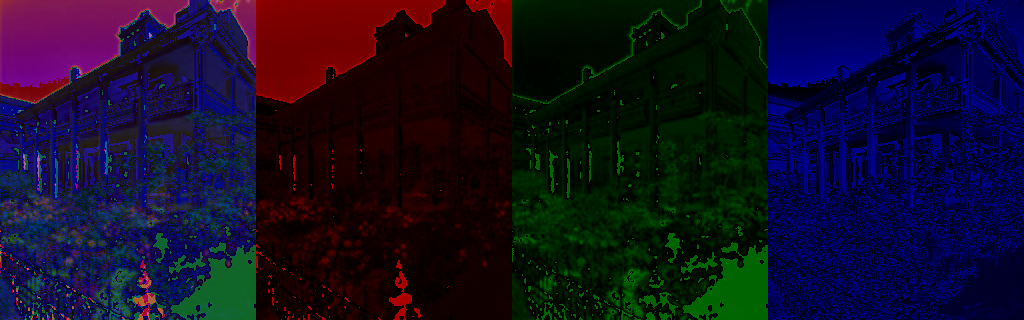

In [53]:
outp_opp = ConvertColourSpace(image, 'opponent')

#### Normalized RGB colour space

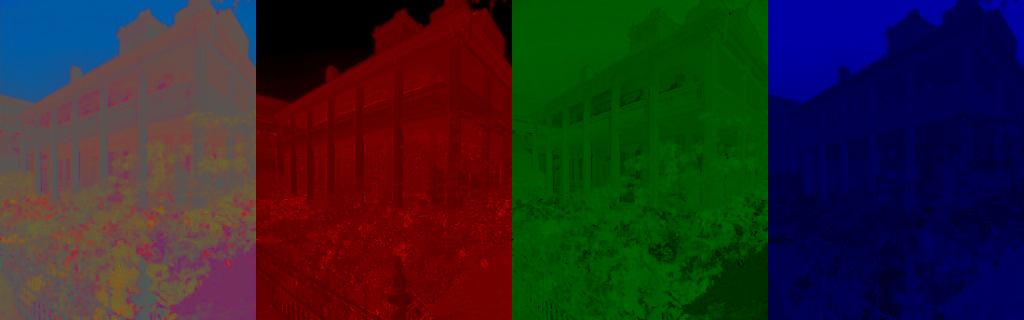

In [54]:
outp_normed = ConvertColourSpace(image, 'rgb')

#### Greyscale images

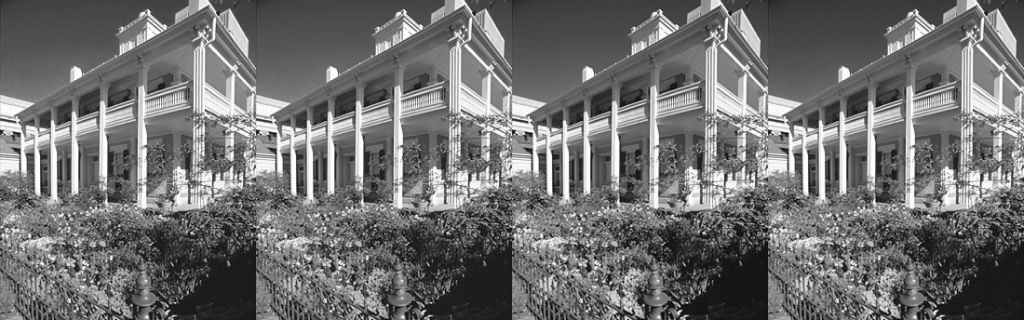

In [40]:
grey1, grey2, grey3, grey4 = ConvertColourSpace(image, 'gray')
concat = cv2.hconcat([grey1, grey2, grey3, grey4])
cv2_imshow(concat)

In [66]:
def visualize_hsv(input_image):

  input_image = input_image.astype(np.float32)
  hue = input_image.copy()
  hue[:,:,1] = 1
  hue[:,:,2] = 1

  #hue = cv2.cvtColor(hue,cv2.COLOR_HSV2BGR)

  sat = input_image.copy()
  sat[:,:,0] = 1
  sat[:,:,2] = 1
  #sat = cv2.cvtColor(sat,cv2.COLOR_HSV2BGR)

  val = input_image.copy()
  val[:,:,0] = 1
  val[:,:,1] = 0
  #val = cv2.cvtColor(val,cv2.COLOR_HSV2BGR)

  concat = cv2.hconcat([input_image, hue, sat, val])

  cv2_imshow(concat)

#### HSV colour space

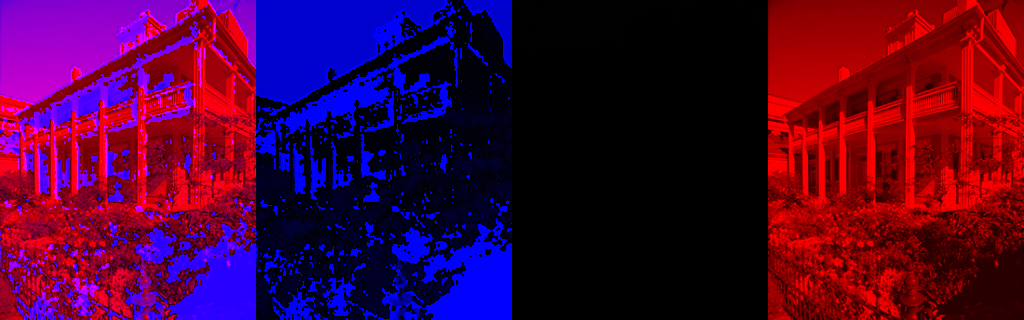

In [70]:
outp_hsv = ConvertColourSpace(image, 'hsv')
visualize_hsv(outp_hsv)

#### YCbCr

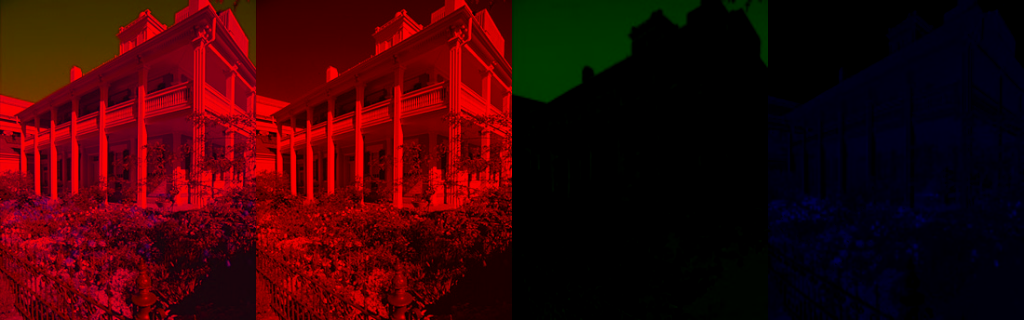

In [72]:
outp_yc = ConvertColourSpace(image, 'ycbcr')

### 2.3 Colour Space Properties (5pts)

Explain each of those 5 colour spaces and their properties. What are the benefits of using a different colour space other than RGB? Provide reasons for each of the above cases. You can include your observations from the visualizations.

**Answer:**

*1. Opponent:* <br>
*The Opponent process depends on certain colours and their opposites, six in total. The opponent of white is black, the opponent of green is red and the opponent of yellow is blue. In the case of black and white, it detects variation in light and dark areas (luminance), like Y would do for YCbCr and Value for HSV. This is based on how the human eyes work. F.e. illusions where you have to stare at a red dot for a certain amount of time, and when you look away you will see green instead (which are two opponents). Another example is when you turn your phone to negative. The most obvious differences is that white backgrounds turn black and black texts turn white. But all the green spaces also turn red (and vice versa) and all the yellow spaces blue (and vice versa). <br>
The output of `rgb2opponent(image);` gives a few images, and the red very clearly shows the amount of green in the original image, since this new red image is very detailed.*

*2. RGB:*<br>
*RGB is a colour space that is an intuitive model based on the values of the colours red, green and blue. Not all of these three are the primary colours as you would know, this is because light (wavelengths) differ from f.e. paints. Mixing all three colours from RGB makes white, while mixing all three primary colours makes black. By mixing the three colours and giving them varying values ranging between 0 and 255, loads of other colours can be created. <br>
With RGB it is possible to split images into either of the colours. This could be used for determining different objects in an image (sky is blue, plant is green, fire is red). This can also be used for singling out certain objects. For example if you want to count the amount of red roses in a field, or the amount of green leaves on a flower. Some more general applications of RGB are color ﬁltering, segmentation, and analysis in image processing. Some downsides however are that the medium on which the colours are displayed or other lighting (such as the sun or artificial light with a red-ish or blue-ish shade) can influence how the colour is perceived. <br>
An example within this assignment where RGB was used, is in `2.2. Colour Space Conversion`, where the image is shown with another one of the three colours being the colour of focus each time. The house consists of very little blue spaces and a lot more of red and green. In the three corresponding images, the blue version shows quite a lot of black spaces at the place of the house, while especially the red version shows more details of the house and the plants.* <br> 

*3. HSV:*<br>
*HSV stands for Hue, Saturation and Value, which are the three properties of the HSV colour space. Hue is the colour (which is similar to red, green and blue from RGB), Saturation is the pureness of the colour (neon colours have a high saturation and pastels a lower saturation) and Value is the brigtness/intensity of the colour (ranges from black, shadowed places, to white, highlights).<br>
A benefit of using HSV is that it is possible to create a feeling of dimensions, because you can use not only the colour/Hue itself (like RGB does), but also de lighting in the image (by adjusting the Saturation and Value). Because this model doesn't just use the base-colours, but more dimensions, HSV is more similar to how the human eye works than RGB is. Calculations however are more complicated. But luckily, it is possible to convert the HSV colour space to an RGB colour space.* <br>

*4. YCbCr:*<br>
*YCbCr is a colour space that consists of three different properties, namely Y (the light intensity/luma of the colour), Cb (the blue component relative to the green component) and Cr (the red component relative to the green component). This colour space has a similarity to the RGB colour space regarding the colours used as properties. In RGB however they are used as independent colours, and in YCbCr they are dependent on the green component. Green is the colour human eyes are most sensitive to. Cb and Cr as `(B-Y)` for Cb and `(R-Y)` for Cr. When seperating an image based on these three properties, you would get a grescale copy of the original image in the case of Y, since this shows just the lighter and darker spaces in the image. Cb shows all the where green-ish and blue-ish spaces, and Cr all the green-ish and red-ish spaces. The last two do not show any differences regarding lights or shades. <br>
Whenever the goal is to compress a video or image where luminance and/or chrominance are of importance, it is much more useful to use YCbCr to do this than to use f.e. RGB, because YCbCr can seperate those much more effectively and much less (computationally) expensive.* <br>

*5. Gray:* <br>
*Gray (also known as Grayscale) is not just converting to image to a binary black-and-white image. Gray can vary from very light shades (nearly white) to very dark sahdes (nearly black), but it does mean filtering out all of the colours in the image. Similar to the grayscale image Y would give in the case of YCbCr. Each pixel is seen as a single case of reflecting light, the more light it reflects the closer to white the pixels is.<br>
Computationally analyzing an image in grayscale is much faster and much less (computationally) expensive than images with colour. In situations where colour doesn't matter, it is beneficial to convert the image or video to grayscale and analyze it like that. In cases where colour is of importance (such as tulips of loads of different colours in a field) grayscale is not effective (if the goal is f.e. to seperate the tulips of different colours).*


### 2.4 More on Colour Spaces (2pts)

Find one more colour space from the literature and simply explain its properties and give a use case.

**Answer:**

*HSL:*<br>
*HSL is a colour space that is very similar to HSV, but instead of Value, the third property is Lightness. Other terms that are used interchangably with Lightness are Luminance and Intensity. The biggest difference between HSV's Value and HSL's Lightness, is that Lightness also depends on the surface the light/whiteness is emitted of. F.e. the sun (which is the direct source of the light) and the moon (which is the reflection of light) have a different Lightness (the sun is higher).* <br>
*The two images below show the geometric representation of HSL and HSV. The main difference is the part thats white. IN the case of HSL, the entire upper part is white (light) and with HSV it's only the middle part that is white.*

![HSL and HSV](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/Hsl-hsv_models.svg/1200px-Hsl-hsv_models.svg.png)


## 3 Intrinsic Image Decomposition (15pts)
Intrinsic image decomposition is the process of separating an image into its formation components, such as reflectance (albedo) and shading (illumination). <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) Then, under the assumption of body (diffuse) reflection, linear sensor response and narrow band filters, the decomposition of the observed image $I(\vec{x})$ at position $\vec{x}$ can be approximated as the element-wise product of its albedo $R(\vec{x})$ and shading $S(\vec{x})$ intrinsics:

$$I(\vec{x})=R(\vec{x}) \times S(\vec{x})$$

In this part of the assignment, you will experiment with intrinsic image components to perform one of the computational photography applications; material recolouring. For the experiments, we will use images from a synthetic intrinsic image dataset. <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2)

<a name="cite_note-1"></a><small>1. [^](#cite_ref-1) H. G. Barrow and J. M. Tenenbaum. Recovering intrinsic scene characteristics from images. Computer Vision Systems, pages 3-26, 1978.</small>

<a name="cite_note-2"></a><small>2. [^](#cite_ref-1) http://www.cic.uab.cat/Datasets/synthetic_intrinsic_image_dataset/



1. What other components can an image be decomposed other than albedo and shading Give an example and explain your reasoning. *(4pts)*

<font color = 'red'> **Answer:** </font>

*Aside from splitting an image into shaded parts and lighted parts, you can also split an image in different colours. This would be based on RGB. Splitting an image into different colours can help determine and find different shapes and objects. <br> For example an image of a field with flowers. Decomposing this image into red, green and blue shows the flowers, the grass and the sky, because these are the corresponding colours.*

2. If you check the literature, you will see that almost all the intrinsic image decomposition datasets are composed of synthetic images. What might be the reason for that? *(2pts)*

<font color = 'red'> **Answer:** </font>

*Synthetic images (computer generated images to represent the real world, f.e. VR.)(https://synthetic-images.com/) allow you to view an image or an object with lighting coming from different angles. Image X shows an example of these different light-angles and the corresponding shading. Using such images shows how the image would interact with light, and if this is the desired behavior.* <br>
*The book (A Modern Approach) uses these synthetic images for recovering the normal field of the object. Which they can do because the images are 'all obtained in an orthographic view from the same viewing position' (A Modern Approach, Chapter 5, Figure 5.10. https://canvas.uva.nl/courses/32252/files/6868416/download?wrap=1).*

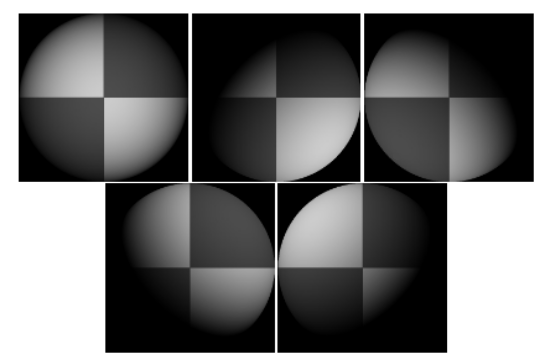

3. Show that you can actually reconstruct the original *turtle.png* image from its intrinsics using *turtle_albedo.png* and *turtle_shading.png*. In the end, your script should output a figure displaying the original image, its intrinsic images and the reconstructed one. Complete the code for function **iid_image_formation()**. *(4pts)*

In [ ]:
def iid_image_formation(albedo_img, shading_img):
    """
    ================
    Your code here
    ================
    """

    turtle = cv2.imread(r'./images/intrinsic_images/turtle.png')
    turtle = cv2.cvtColor(turtle, cv2.COLOR_BGR2RGB)
    
    albedo_img = albedo_img/255
    shading_img = shading_img/255
    
    reconstructed = albedo_img * shading_img

    fig, ax = plt.subplots(2,2, figsize=(15, 15))
    
    ax1, ax2, ax3, ax4 = ax[0,0], ax[0,1], ax[1,0], ax[1,1]

    ax1.set_title('Original')
    ax1.imshow(turtle)

    ax2.set_title('Albedo')
    ax2.imshow(albedo_img)

    ax3.set_title('Shading')
    ax3.imshow(shading_img)

    ax4.set_title('Reconstructed')
    ax4.imshow(reconstructed)
    
    return

#### Load Images

In [ ]:
turtle_shading = cv2.imread(r'./images/intrinsic_images/turtle_shading.png')
turtle_albedo = cv2.imread(r'./images/intrinsic_images/turtle_albedo.png')

#### Convert to RGB

In [ ]:
turtle_shading = cv2.cvtColor(turtle_shading, cv2.COLOR_BGR2RGB)
turtle_albedo = cv2.cvtColor(turtle_albedo, cv2.COLOR_BGR2RGB)

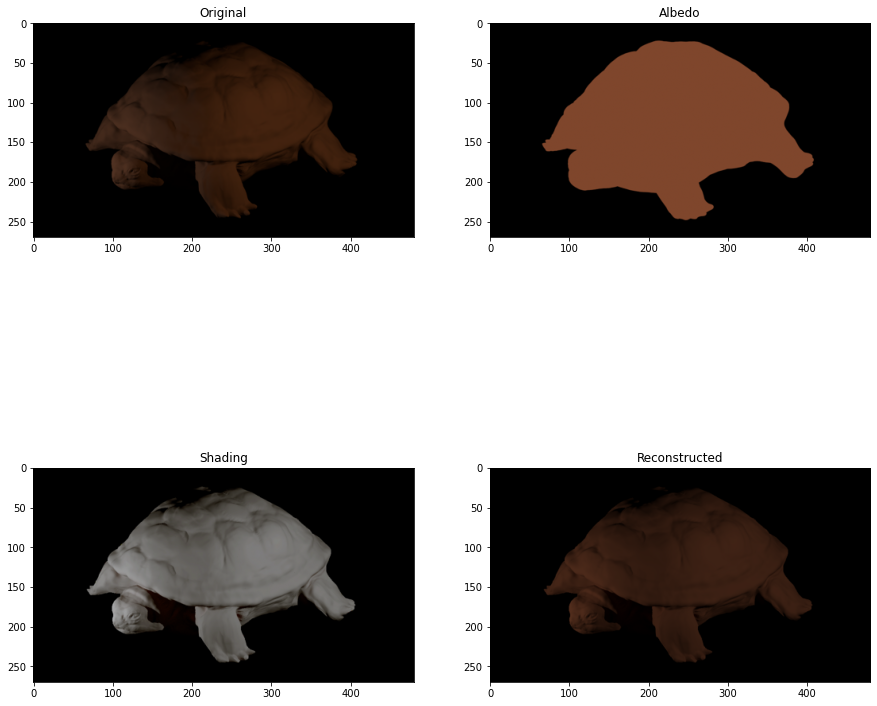

In [ ]:
iid_image_formation(turtle_albedo, turtle_shading)

### Recoloring *(5pts)*
Manipulating colours in photographs is an important problem with many applications in computer vision. Since the aim for recolouring algorithms is just to manipulate colours, better results can be obtained for such a task if the albedo image is available as it is independent of confounding illumination effects.

Assume that you are given the *turtle.png* image and you have access to its
intrinsic images *turtle_albedo.png* and *turtle_shading.png*.
1. Find out the true material colour of the turtle in RGB space (which is uniform in this case).

**Answer:** <br>
*The albedo image shows the turtle without any shading (those are filtered out and visible in the shading image), and the RGB-value that corresponds with the brown-ish colour that is left over is: `rgb(123,67,43)`.*

2. Recolour the turtle image with pure green (0, 255, 0). Display the original turtle image and the recoloured version on the same figure. Complete the code for function **recoloring()**.

In [ ]:
def recoloring(albedo_img, shading_img):
    """
    ================
    Your code here
    ================
    """
    turtle = cv2.imread(r'./images/intrinsic_images/turtle.png')
    turtle = cv2.cvtColor(turtle, cv2.COLOR_BGR2RGB)
    albedo_img = albedo_img/255
    shading_img = shading_img/255
    for i in range(3):
        if i == 1:
            albedo_img[albedo_img[:,:,i] > 0, 1] = 1
        else:
            albedo_img[:,:,i] = 0

    green = albedo_img * shading_img
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 15))
    ax1.set_title('Original')
    ax1.imshow(turtle)

    ax2.set_title('Recoloured')
    ax2.imshow(green)
    
    return

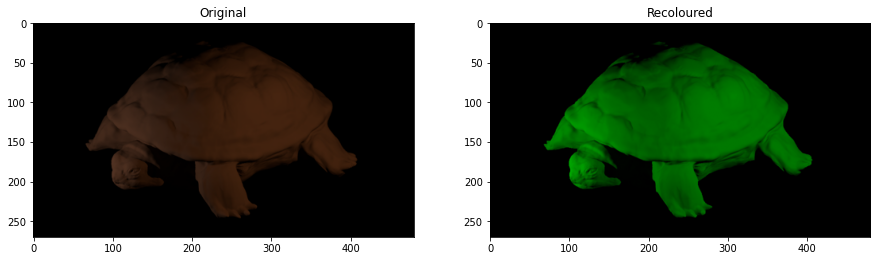

In [ ]:
recoloring(turtle_albedo, turtle_shading)

3. Although you have recoloured the object with pure green, the reconstructed images do not seem to display those pure colors and thus the colour distributions over the object do not appear uniform. Explain the reason.

**Answer:**<br>
*The RGB-value of the true colour was `rgb(123,67,43)`, recolouring the object with pure green changes this value to `rgb(123,255,43)`. If you follow [this link](https://g.co/kgs/NuGTw8) it will show the colour that the new RGB-value creates. If you look at the lighter parts on the turtle (places with little to no shading), it is clear that the green in those areas is very similar to the green in the image below.*

Note that this was a simple case where the image is synthetic, object centered and has only one colour, and you have access to its ground-truth intrinsic images. Real world scenarios require more than just replacing a single colour with another, not to mention the complexity of achieving a decent intrinsic image decomposition.

## 4 Colour Constancy (15pts)

Colour constancy is the ability to perceive colors of objects, invariant to the colour of the light source. The aim for colour constancy algorithms is first to estimate the illuminant of the light source, and then correct the image so that the corrected image appears to be taken under a canonical (white) light source. The task of the automatic white balance (AWB) is to do the same in digital cameras so that the images taken by a digital camera look as natural as possible.

In this part of the assignment, you will implement the most famous colour constancy algorithm; *Grey-World Algorithm*.

### Grey-World Algorithm
The algorithm assumes that, under a white light source, the average colour in a scene should be achromatic (grey, [128, 128, 128]).

1. Complete the function to apply colour correction to an RGB image by using Grey-World algorithm. Display the original image and the colour corrected one on the same figure. Use awb.jpg image to test your algorithm. In the end, you should see that the reddish colour cast on the image is removed and it looks more natural.

  ***Note:*** You do not need to apply any pre or post processing steps. For the calculation or processing, you are not allowed to use any available code or any dedicated library function except *standard Numpy functions*.
   
   ***Hint:*** Check the von Kries model for this step.


In [ ]:
def grey_world(awb_img):
    """
    ================
    Your code here
    ================
    """

    im_avg = 128
    rgb_means = awb_img.mean(axis=(0,1))
    
    awb_grey_world = awb_img * (im_avg/rgb_means)
    awb_grey_world = awb_grey_world.clip(0,255).astype(int)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 15))
    ax1.set_title('Original')
    ax1.imshow(awb_img)

    ax2.set_title('Grey-World')
    ax2.imshow(awb_grey_world)

    return

In [ ]:
awb = cv2.imread(r'./images/awb/awb.jpg')

In [ ]:
awb = cv2.cvtColor(awb, cv2.COLOR_BGR2RGB)

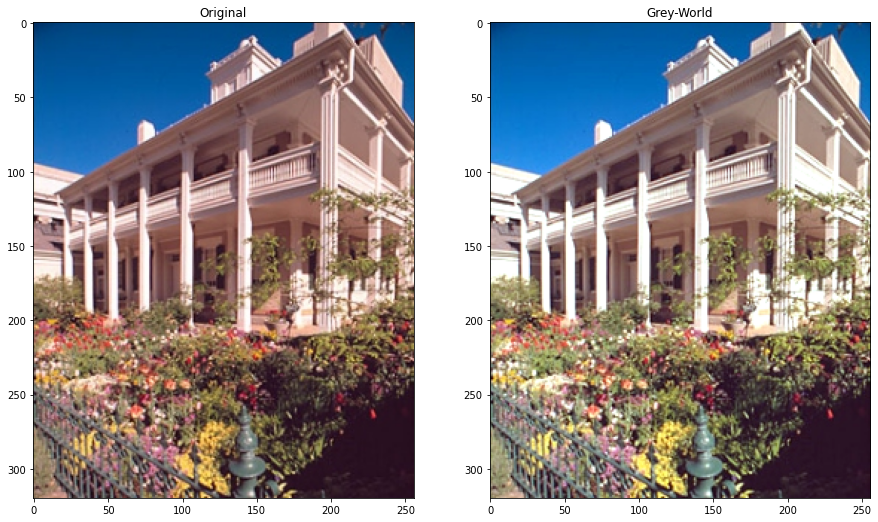

In [ ]:
grey_world(awb)

2. Give an example case for Grey-World Algorithm on where it might fail. Remember to include your reasoning.

<font color = 'red'> **Answer:** </font> **Grey-World Algorithm was designed for the static scenes, because of that it might fail when there is big change in the image geometrical reflectance. It means that when i.e. objects disappear from the scene or new objects appear in the scene or when there is a big change in illumination intesivity.**

Source: http://www.dia.fi.upm.es/~pcr/publications/impcomm2001.pdf

3. Find out one more colour constancy algorithms from the literature and explain it briefly.

<font color='red'> **Answer:** </font> **Scale‭ ‬by‭ ‬max‭ ‬algorithm: in this algorithm‭ ‬the‭ ‬estimate‭ ‬of‭ ‬the‭ ‬illuminant‭ ‬is‭ ‬obtained‭ ‬by‭ ‬measuring
the maximum of the responses in each channel.‭ ‬The estimation formulation is almost same as the Grey-world, only difference is that for the sensor responses in each channel the maximum is used instead of the mean.‭ ‬It‭ ‬is‭ ‬a‭ ‬subset‭ ‬of‭ ‬the‭ ‬Bayesian
approach‭ ‬under‭ ‬the‭ ‬assumption‭ ‬that‭ ‬the reﬂectance‭ ‬is‭ ‬independent and‭ ‬uniform‭. ‬The presence‭ ‬of‭ ‬specularities‭ ‬in‭ ‬the‭ ‬images‭ ‬means‭ ‬that‭ ‬the‭ ‬maximum reﬂectance‭ ‬is greater‭ ‬than
pure‭ ‬white‭ ‬and‭ ‬it‭ ‬leads‭ ‬to‭ ‬incorrect‭ ‬illuminant‭ ‬estimation.‭ ‬Alternatively,‭ ‬these‭ ‬specularities can be used to measure the illuminant chromaticity.**

Source: June 2006 Journal of Pattern Recognition Research
DOI:10.13176/11.9